In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [80]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_pickle('DO_NOT_OVERWRITE.pkl')

In [81]:
df.head()

,year,team,wins,pts/g,tot_pts_allowed,net_pts,total_dvoa,def_dvoa,off_dvoa,st_dvoa,tot_pts,scrm_plays,yds/g,yds/p,1st/g,3rd_made,3rd_att,3rd_pct,4th_made,4th_att,4th_pct,pen_off,pen_yards_off,top/g,off_fum,off_fum_lost,to_diff,rush_att,rush_att/g,rush_yds,rush_avg,rush_yds/g,rush_td,rush_20+,rush_40+,tackles,sacks,int,def_force_fum,def_fum_rec,drives,yds/dr,pts/dr,to/dr,int/dr,fum/dr,los/dr,plays/dr,top/dr,dsr,1st_x_3rd_pct,1_3_4,1st_total,1st/scrm,sack/tack,pts/top/g,long_rush_td
0,2002,49ers,10,22.9,351,16,13.0,2.1,19.2,-4.1,367,1082,356.3,5.3,21.4,127,243,52,8,13,62,87,725,32.39,15,7,10,489,30.6,2244,4.6,140.2,16,12,1,842,32.0,19,23,8,167,33.59,2.10,.096,.060,.036,31.34,6.65,3.06,.728,1112.8,68993.6,342.4,0.316451,0.038005,0.707008,12
1,2003,49ers,7,24.0,337,47,-0.9,3.2,7.8,-5.6,384,1038,355.4,5.5,19.6,86,215,40,5,19,26,104,807,31.09,24,10,12,499,31.2,2279,4.6,142.4,16,13,2,819,42.0,23,23,13,192,29.29,1.94,.125,.078,.047,33.96,5.57,2.35,.676,784.0,20384.0,313.6,0.302119,0.051282,0.771952,26
2,2004,49ers,2,16.2,452,-193,-41.8,19.4,-21.2,-1.2,259,1026,286.6,4.5,17.5,72,222,32,14,19,74,103,859,29.18,33,19,-19,413,25.8,1449,3.5,90.6,10,7,1,871,29.0,9,24,12,199,22.59,1.19,.201,.106,.095,28.78,5.27,2.21,.618,560.0,41440.0,280.0,0.272904,0.033295,0.555175,7
3,2005,49ers,4,14.9,428,-189,-55.5,16.6,-40.4,1.5,239,865,224.2,4.1,11.9,49,204,24,5,8,62,106,780,27.37,31,14,-9,428,26.8,1689,3.9,105.6,9,11,3,902,28.0,16,18,10,192,17.96,1.03,.167,.109,.057,27.60,4.62,2.17,.522,285.6,17707.2,190.4,0.220116,0.031042,0.544392,33
4,2006,49ers,7,18.6,412,-114,-19.4,11.4,-8.2,0.1,298,918,303.8,5.3,15.2,72,209,34,6,11,54,93,818,29.00,24,16,-5,439,27.4,2172,4.9,135.8,12,20,6,854,34.0,14,23,13,185,25.77,1.53,.157,.081,.076,30.08,5.13,2.30,.608,516.8,27907.2,243.2,0.264924,0.039813,0.641379,120


**Remove Test**

In [88]:
#KFOLD, manual#

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


X, y = df.drop(['team', 'year', 'wins'],axis=1), df['wins']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1) #hold out 20% of the data for final testing

# test splits should be the same if stats remains

**KFOLD to Find Best Model**

In [93]:
#run the KfoldCV on Linear, Ridge, and Lasso models to find best model

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state = 1)
cv_lm_r2s, cv_lm_reg_r2s, cv_lm_lasso_r2s  = [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    lm_lasso = Lasso(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    #lasso with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_lasso.fit(X_train_scaled, y_train)
    cv_lm_lasso_r2s.append(lm_lasso.score(X_val_scaled, y_val))
    
    #Poly regression on linear
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    
    #Poly regression on ridge
    poly = PolynomialFeatures(degree=2) 
    
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_val_poly_scaled = scaler.fit_transform(X_val_poly)
    
    lm_poly2 = Ridge(alpha=1)
    lm_poly2.fit(X_train_poly_scaled, y_train)
    

print('Simple regression scores: ', cv_lm_r2s, '\n')
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
print('Lasso scores: ', cv_lm_lasso_r2s, '\n')

print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression Ridge val R^2: {lm_poly2.score(X_val_poly_scaled, y_val):.3f}')
print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')

Simple regression scores:  [0.8480759750266922, 0.8500597378185083, 0.7796106887387656, 0.8742948373932602, 0.8721029841412099] 

Ridge scores:  [0.8509382736839901, 0.8519405117330208, 0.7756458035241252, 0.881469916556121, 0.8773184867604082] 

Lasso scores:  [0.7287399823352898, 0.7625420636766311, 0.7046574498017737, 0.7243521058165909, 0.7662570587449871] 

Degree 2 polynomial regression val R^2: -1.100
Degree 2 polynomial regression Ridge val R^2: 0.662
Simple mean cv r^2: 0.845 +- 0.034
Ridge mean cv r^2: 0.847 +- 0.038
Lasso mean cv r^2: 0.737 +- 0.024


In [8]:
selected_columns = ['pts/g', 'tot_pts_allowed', 'net_pts', 'total_dvoa', 'def_dvoa',
       'off_dvoa', 'st_dvoa', 'tot_pts', 'scrm_plays', 'yds/g', 'yds/p',
       '1st/g', '3rd_made', '3rd_att', '3rd_pct', '4th_made', '4th_att',
       '4th_pct', 'pen_off', 'pen_yards_off', 'top/g', 'off_fum',
       'off_fum_lost', 'to_diff', 'rush_att', 'rush_att/g', 'rush_yds',
       'rush_avg', 'rush_yds/g', 'rush_td', 'rush_20+', 'rush_40+', 'tackles',
       'sacks', 'int', 'def_force_fum', 'def_fum_rec', 'drives', 'yds/dr',
       'pts/dr', 'to/dr', 'int/dr', 'fum/dr', 'los/dr', 'plays/dr', 'top/dr',
       'dsr', '1st_x_3rd_pct', '1_3_4', '1st_total', '1st/scrm', 'sack/tack',
       'pts/top/g', 'long_rush_td']

In [76]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train)

## Scale the Predictors on both the train and test set. test to be used later.
X_tr = std.transform(X_train)
X_te = std.transform(X_test)

# Run the cross validation, find the best alpha
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train)

/Users/samuelouimet/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [78]:
ridge_model.alpha_

17.225859653987875

**fit on all data except test with new alpha_param**

In [31]:
# Do i need to scale x here? YES

X_scaled = scaler.fit_transform(X)

ridge_model.fit(X_scaled,y)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [32]:
ridge_model.score(X_scaled,y)

0.8738583367680092

**RUN FINAL TESTS**

In [33]:
test_set_pred = ridge_model.predict(X_te)

In [34]:
r2_score(y_test, test_set_pred)

0.7972825591483295

In [99]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

1.1232619055446196

Text(0.5, 1.0, 'Predicted vs. Observed Win Totals')

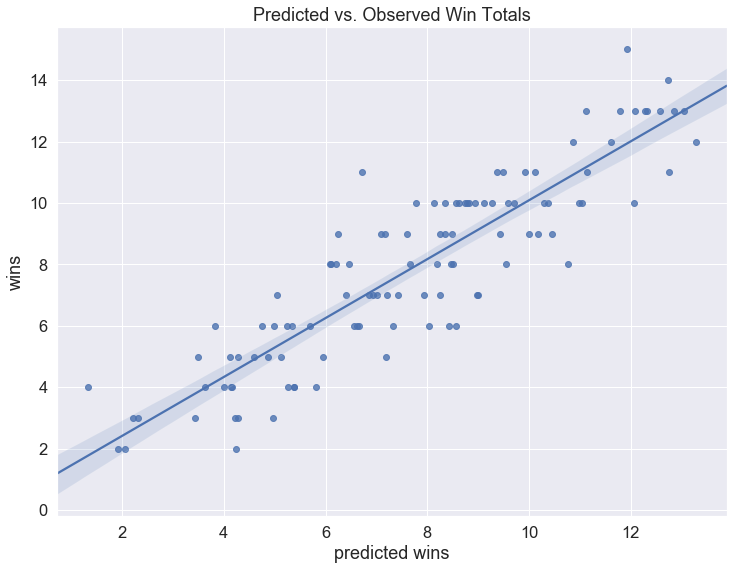

In [124]:
sns.set(font_scale=1.5)
plt.figure(figsize=(12,9))
#sns.scatterplot(test_set_pred, y_test, hue=y_test)
sns.regplot(x=test_set_pred, y=y_test);
plt.xlabel('predicted wins')



plt.title('Predicted vs. Observed Win Totals')

In [83]:
ridge_model.coef_

array([ 0.24559804, -0.89925913,  0.70544928,  0.0053469 , -0.09599201,
       -0.06825127,  0.06573765,  0.24617448,  0.12937665,  0.00494563,
        0.04809833, -0.02939227, -0.01686001, -0.18767479,  0.12470149,
        0.08578137, -0.29964938, -0.13226691, -0.05145545,  0.0283757 ,
        0.11046717, -0.07852586, -0.0084564 ,  0.10396265,  0.07675125,
        0.08188813, -0.05220222, -0.26849065, -0.05152185, -0.05812563,
        0.23604805,  0.02379446,  0.0745049 , -0.07254471,  0.04790968,
       -0.0056138 ,  0.13017794,  0.0268459 ,  0.24183779,  0.1691639 ,
       -0.08715898, -0.14840869,  0.00796492,  0.05809747, -0.13260952,
        0.0820757 , -0.00104608,  0.08024679,  0.01800663, -0.02939227,
       -0.05984369,  0.08907387,  0.28388711, -0.0414336 ])

In [91]:
#### DO NOT RE RUN ####

features = X

In [94]:
features.columns

Index(['pts/g', 'tot_pts_allowed', 'net_pts', 'total_dvoa', 'def_dvoa',
       'off_dvoa', 'st_dvoa', 'tot_pts', 'scrm_plays', 'yds/g', 'yds/p',
       '1st/g', '3rd_made', '3rd_att', '3rd_pct', '4th_made', '4th_att',
       '4th_pct', 'pen_off', 'pen_yards_off', 'top/g', 'off_fum',
       'off_fum_lost', 'to_diff', 'rush_att', 'rush_att/g', 'rush_yds',
       'rush_avg', 'rush_yds/g', 'rush_td', 'rush_20+', 'rush_40+', 'tackles',
       'sacks', 'int', 'def_force_fum', 'def_fum_rec', 'drives', 'yds/dr',
       'pts/dr', 'to/dr', 'int/dr', 'fum/dr', 'los/dr', 'plays/dr', 'top/dr',
       'dsr', '1st_x_3rd_pct', '1_3_4', '1st_total', '1st/scrm', 'sack/tack',
       'pts/top/g', 'long_rush_td'],
      dtype='object')

In [97]:
features.shape

(434, 54)

In [121]:
err_vec_val = np.zeros(len(alphavec))

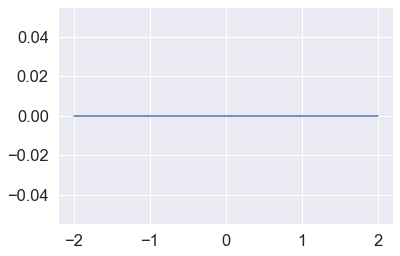

In [123]:
plt.plot(np.log10(alphavec), err_vec_val)